# Instrument Control Outline

1. The unique naming of instruments
2. Definition of an InstrumentSheet
3. Inherit from VisaInstrument
4. The behavior of the method intialize()
5. Configuration Settings (set/get)
6. Measurement (measure)

## Naming of Instruments

Manufacturer_Model_RoomNumber_Iterator<br/>
ex:<br/>
RS_ZVA110_4639_001<br/>
Keysight_E8361A_4639_001

## Defining an InstrumentSheet


## Inherit from VisaInstrument class
```python
class E8361A(VisaInstrument):
    pass
```

This gives the methods
+ set_state
+ get_state
+ load_state
+ read
+ write 
+ ask and query (same command)

and automatically populates any static metadata fields from the InstrumentSheet


## All specific instruments should have an intialize method
```python
vna=E8631("Keysight_E361A_4639_001")
vna.initialize()
```

## Configuration Commands
Commands that change the state fo the instrument but do not take a measurement should be named set_configuration and ones that read it should be get_configuration. These commands should take either numeric types or strings, the units should be specified in the doc string of the method.

```python
vna.set_IFBW(10)
vna.get_IFBW()
vna.set_power('0')
```

## Measurement Commands
Commands that take a measurement and return something should be named using measure_typeofmeasurement
```python
sparameters=vna.measure_sparameters()
new_power_reading=power_meter.measure_power()
```

In [1]:
from pyMeasure import *

Importing Code.Analysis.Fitting
It took 11.838 s to import Code.Analysis.Fitting
Importing Code.DataHandlers.GeneralModels
It took 0.108 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.GraphModels
The module smithplot was not found,please put it on the python path
It took 14.857 s to import Code.DataHandlers.GraphModels
Importing Code.DataHandlers.HTMLModels
It took 0.005 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.MUFModels
It took 0.006 s to import Code.DataHandlers.MUFModels
Importing Code.DataHandlers.NISTModels
It took 0.005 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.StatistiCALModels
It took 0.004 s to import Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
It took 0.036 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.Translations
It took 0.012 s to import Code.DataHandlers.Transla

In [65]:
import time

In [52]:
class VNA(VisaInstrument):
    """Control class for Keysight E8631A PNA """
    def __init__(self,resource_name=None,**options):
        """Initializes the E8631A control class"""
        defaults={"state_directory":os.getcwd()}
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        VisaInstrument.__init__(self,resource_name,**self.options)
        self.power=self.get_power()
        self.IFBW=self.get_IFBW()
        #this should be if SENS:SWE:TYPE? is LIN
        start=float(self.query("SENS:FREQ:START?").replace("\n",""))
        stop=float(self.query("SENS:FREQ:STOP?").replace("\n",""))
        number_points=int(self.query("SENS:SWE:POIN?").replace("\n",""))
        self.frequency_list=np.linspace(start,stop,number_points)

    def initialize(self):
        """Intializes the system"""
        self.write("SYST:FPRESET")
        self.write("DISPlay:WINDow1:STATE ON")
        self.write("CALCulate:PARameter:DEFine 'S11',S11")
        self.write("DISPlay:WINDow1:TRACe1:FEED 'S11'")
        self.write("CALCulate:PARameter:DEFine 'S12',S12")
        self.write("DISPlay:WINDow1:TRACe2:FEED 'S12'")
        self.write("CALCulate:PARameter:DEFine 'S21',S21")
        self.write("DISPlay:WINDow1:TRACe3:FEED 'S21'")
        self.write("CALCulate:PARameter:DEFine 'S22',S22")
        self.write("DISPlay:WINDow1:TRACe4:FEED 'S22'")
        start=float(self.query("SENS:FREQ:START?").replace("\n",""))
        stop=float(self.query("SENS:FREQ:STOP?").replace("\n",""))
        number_points=int(self.query("SENS:SWE:POIN?").replace("\n",""))
        self.frequency_list=np.linspace(start,stop,number_points)

        
    def set_power(self,power):
        """Sets the power of the Instrument in dbm"""
        self.write('SOUR:POW {0}'.format(power))
    def get_power(self):
        "Returns the power of the instrument in dbm"
        return self.query('SOUR:POW?')
    def set_IFBW(self,ifbw):
        """Sets the IF Bandwidth of the instrument in Hz"""
        self.write('SENS:BAND {0}'.format(ifbw))
    def get_IFBW(self):
        """Returns the IFBW of the instrument in Hz"""
        return self.query('SENS:BAND?')
    def set_frequency(self,start,stop=None,number_points=None,step=None,units='Hz'):
        """Sets the VNA to a linear mode and creates a single entry in the frequency table. If start is the only specified
        parameter sets the entry to start=stop and number_points = 1. If step is specified calculates the number of points 
        and sets start, stop, number_points on the VNA. It also stores the value into the attribute frequency_list. 
        """
        if stop is None and number_points is None:
            stop=start
            number_points=1
        if number_points is None and not step is None:
            number_points = round((stop-start)/step) + 1
        self.frequency_list=np.linspace(start,stop,number_points)
        self.write('SWE:TYPE LIN')
        self.write("SENS:FREQ:START {0}".format(start))
        self.write("SENS:FREQ:STOP {0}".format(stop))
        self.write("SENS:SWE:POIN {0}".format(number_points))
    def get_frequency(self):
        "Returns the frequency in python list format"
        return self.frequency_list
    def is_busy(self):
        """Checks if the insturment is currently doing something"""
        opc=bool(self.query("*OPC?"))
        return not opc
    
    def measure_sparameters(self,**options):
        """Triggers a single sparameter measurement for all 4 parameters and returns a SP2V1 object"""
        defaults={}
        self.measure_sparameter_options={}
        for key,value in defaults.iteritems():
            self.measure_sparameter_options[key]=value
        for key,value in options:
            self.measure_sparameter_options[key]=value
        # wait for other functions to be completed
        while self.is_busy():
            time.sleep(.01)
        # Set the format to ascii and set up sweep definitions
        self.write('FORM:ASCII')
        # First get the Sparameter lists
        self.write('CALC:PAR:SEL S11')
        self.write('CALC:FORM MLIN')
        s11_string=self.query('CALC:DATA? SDATA')
        self.write('CALC:PAR:SEL S12')
        self.write('CALC:FORM MLIN')
        s12_string=self.query('CALC:DATA? SDATA')
        self.write('CALC:PAR:SEL S21')
        self.write('CALC:FORM MLIN')
        s21_string=self.query('CALC:DATA? SDATA')
        self.write('CALC:PAR:SEL S22')
        self.write('CALC:FORM MLIN')
        s22_string=self.query('CALC:DATA? SDATA')
        # String Parsing
        s11_list=s11_string.replace("\n","").split(",")
        s12_list=s12_string.replace("\n","").split(",")
        s21_list=s21_string.replace("\n","").split(",")
        s22_list=s22_string.replace("\n","").split(",")
        # Construct a list of lists that is data in RI format
        reS11=s11_list[0::2]
        imS11=s11_list[1::2]
        reS12=s12_list[0::2]
        imS12=s12_list[1::2]
        reS21=s21_list[0::2]
        imS21=s21_list[1::2]
        reS22=s22_list[0::2]
        imS22=s22_list[1::2]
        sparameter_data=[]
        for index,frequency in enumerate(self.frequency_list[:]):
            new_row=[frequency,
                     reS11[index],imS11[index],
                     reS21[index],imS21[index],
                     reS12[index],imS12[index],
                     reS22[index],imS22[index]]
            sparameter_data.append(new_row)
        option_line="# Hz S RI R 50"
        # add some options here about auto saving 
        # do we want comment options?
        s2p=S2PV1(None,option_line=option_line,data=sparameter_data)
        return s2p
        
            

In [63]:
vna=VNA("ZVA110")

In [64]:
vna.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'10000',
 'SENS:CORR:STAT': u'1',
 'SENS:SWE:TYPE': u'LIN',
 'SOUR:POW': u'-10',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'0'}

In [60]:
vna.set_frequency(3*10**8,50*10**9,1000)
print vna.query("*OPC?")
s2p=vna.measure_sparameters()

1



In [62]:
vna.resource_manager.close()

In [23]:
s2p.path

'Two_Port_Sparameter_20170424_001.s2p'

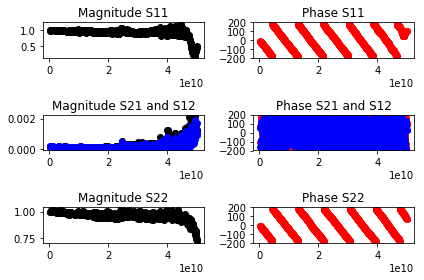

In [61]:
s2p.show();

In [3]:
pna=VisaInstrument("E8361A")

In [4]:
pna.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'+3.50000000000E+004',
 'SENS:CORR:STAT': u'0',
 'SENS:SWE:TYPE': u'SEGM',
 'SOUR:POW': u'-2.00000000000E+001',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'+0.00000000000E+000'}

In [5]:
pna.idn

'Agilent Technologies,E8361A,US43140754,A.07.50.67'

In [11]:
pna.write("SYST:FPRESET")
pna.write("DISPlay:WINDow1:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S11',S11")
pna.write("DISPlay:WINDow1:TRACe1:FEED 'S11'")

(35L, <StatusCode.success: 0>)

In [12]:
pna.write("CALCulate:PARameter:DEFine 'S21',S21")
pna.write("DISPlay:WINDow1:TRACe2:FEED 'S21'")

(35L, <StatusCode.success: 0>)

In [8]:
pna.write("DISPlay:WINDow3:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S12',S12")
pna.write("DISPlay:WINDow3:TRACe3:FEED 'S12'")

(35L, <StatusCode.success: 0>)

In [9]:
pna.write("DISPlay:WINDow4:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S22',S22")
pna.write("DISPlay:WINDow4:TRACe4:FEED 'S22'")

(35L, <StatusCode.success: 0>)

In [15]:
pna.write("SYST:FPRESET")
pna.write("DISPlay:WINDow1:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S11',S11")
pna.write("DISPlay:WINDow1:TRACe1:FEED 'S11'")
pna.write("CALCulate:PARameter:DEFine 'S12',S12")
pna.write("DISPlay:WINDow1:TRACe2:FEED 'S12'")
pna.write("CALCulate:PARameter:DEFine 'S21',S21")
pna.write("DISPlay:WINDow1:TRACe3:FEED 'S21'")
pna.write("CALCulate:PARameter:DEFine 'S22',S22")
pna.write("DISPlay:WINDow1:TRACe4:FEED 'S22'")

(35L, <StatusCode.success: 0>)

In [21]:
pna.write("SENS:SWE:MODE HOLD")
#pna.write("TRIG:SOUR MAN")
#pna.write("CONT:SIGN BNC,TILHIGH")
#pna.write('TRIG:SCOP ALL')
pna.write("SENS1:SWE:MODE GROUPS")

(23L, <StatusCode.success: 0>)

In [20]:
pna.write("SENS:SWE:MODE HOLD")
pna.write("TRIG:SOUR MAN")
pna.write("CONT:SIGN BNC,TILHIGH")

(23L, <StatusCode.success: 0>)

```vb
Private Sub ReadWrite_Click()
Dim i As Integer
Dim t As Integer
Dim q As Integer
Dim dat As String
Dim cmd As String
Dim datum() As Double
GPIB.Configure
GPIB.Write "SYSTem:PRESet;*wai"
'Select the measurement
GPIB.Write "CALCulate:PARameter:SELect 'CH1_S11_1'"
'Read the number of data points
GPIB.Write "SENSe1:SWEep:POIN?"
numpts = GPIB.Read
'Turn continuous sweep off
GPIB.Write "INITiate:CONTinuous OFF"
'Take a sweep
GPIB.Write "INITiate:IMMediate;*wai"
'Ask for the Data
'PICK ONE OF THESE LOCATIONS TO READ
'GPIB.Write "CALCulate:DATA? FDATA" 'Formatted Meas
'GPIB.Write "CALCulate:DATA? FMEM" 'Formatted Memory
GPIB.Write "CALCulate:DATA? SDATA" 'Corrected, Complex Meas
'GPIB.Write "CALCulate:DATA? SMEM" 'Corrected, Complex Memory
'GPIB.Write "CALCulate:DATA? SCORR1" 'Error-Term Directivity
'Number of values returned per data point
```

In [23]:
data=pna.query('CALC:DATA? SDATA')

In [24]:
len(data)

8040

In [26]:
len(data.split(','))

402

In [28]:
pna.ask('SENS:SWE:POIN?')

u'+201\n'

In [32]:
s11_string=pna.query('CALC:DATA? SDATA')
pna.write('CALC:PAR:SEL S12')
s12_string=pna.query('CALC:DATA? SDATA')

In [35]:
len(s11_string.split(','))

402

In [36]:
dir(pna)

['DEFAULT_STATE_QUERY_DICTIONARY',
 'STATE_BUFFER_MAX_LENGTH',
 '__doc__',
 '__init__',
 '__module__',
 '__str__',
 'addEntry',
 'add_entry',
 'alias',
 'ask',
 'commands',
 'current_state',
 'description',
 'document',
 'getImagePath',
 'getQueryDictionary',
 'getState',
 'get_image_path',
 'get_query_dictionary',
 'get_state',
 'idn',
 'image',
 'info_found',
 'info_path',
 'instrument_address',
 'instrument_type',
 'loadState',
 'load_state',
 'location',
 'name',
 'nist_tag',
 'options',
 'path',
 'query',
 'read',
 'resource',
 'resource_manager',
 'root',
 'save',
 'saveCurrentState',
 'saveHtml',
 'saveState',
 'save_HTML',
 'save_current_state',
 'save_state',
 'setState',
 'set_state',
 'show',
 'state_buffer',
 'toHtml',
 'to_HTML',
 'updateCurrentState',
 'update_current_state',
 'write']

In [37]:
pna.location

'Building 81, D121'

In [38]:
pna.name

'E8361A'

In [39]:
pna.commands

[]

In [12]:
zva=VisaInstrument("ZVA110")

VisaIOError: VI_ERROR_CONN_LOST (-1073807194): The connection for the given session has been lost.

In [42]:
pna.resource_manager.close()

VisaIOError: VI_ERROR_CLOSING_FAILED (-1073807338): The VISA driver failed to properly close the session or object reference. This might be due to an error freeing internal or OS resources, a failed network connection, or a lower-level driver or OS error.

In [4]:
zva.idn

'Rohde&Schwarz,ZVA67-4Port,1312700403101122,3.80'

In [7]:
zva_2=VNA("ZVA")

In [8]:
zva_2.initialize()

In [9]:
zva.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'10000',
 'SENS:CORR:STAT': u'1',
 'SENS:SWE:TYPE': u'LIN',
 'SOUR:POW': u'-10',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'0'}

In [11]:
zva.save_current_state()

In [ ]:
class InstrumentState(XMLBase):
    """ An instrument state is an XML file with instrument setting information"""
    def __init__(self,file_path=None,**options):
        """ Intialize the InstrumentState class"""
        defaults={"root":"Instrument_State",
                  "style_sheet":os.path.join(XSLT_REPOSITORY,
                                             'DEFAULT_STATE_STYLE.xsl').replace('\\','/'),
                  "specific_descriptor":'Instrument',
                  "general_descriptor":'State',
                  "directory":None,
                  "extension":'xml',
                  "date":"now",
                  "state_dictionary":None
                  }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value


        XMLBase.__init__(self,file_path,**self.options)
        state_node=self.document.createElement('State')
        self.document.documentElement.appendChild(state_node)
        # This should be in State_Description as State_Timestamp?
        if self.options["date"] in ['now']:
            # Add the Date attribute, this is the time when the state was created
            date=datetime.datetime.utcnow().isoformat()
            Date_attribute=self.document.createAttribute('Date')
            state_node.setAttributeNode(Date_attribute)
            state_node.setAttribute('Date',str(date))
        if self.options["state_dictionary"]:
            for key,value in self.options["state_dictionary"].iteritems():
                new_entry=self.document.createElement('Tuple')
                set_attribute=self.document.createAttribute('Set')
                value_attribute=self.document.createAttribute('Value')
                new_entry.setAttributeNode(set_attribute)
                new_entry.setAttributeNode(value_attribute)
                new_entry.setAttribute('Set',key)
                new_entry.setAttribute('Value',str(value))
                state_node.appendChild(new_entry)
        # this is not the most direct way to define it but it is the most robust I think
        self.state_node=self.document.getElementsByTagName('State')[0]
        self.state_dictionary=dict([(str(node.getAttribute('Set')),
        node.getAttribute('Value')) for node in \
        self.state_node.getElementsByTagName('Tuple')])

    def add_state_description(self,description):
        """Adds the tag named State_Description and its information
        Currently data can be entered as a dictionary of the form {'State_Description':{tag_name:tag_value}}
        or as an element or as a string"""
        try:
            new_element=''
            if type(description) is DictionaryType:
                for key,value in description.iteritems():
                    # This hanldes Tag:Text dictionaries
                    if re.search('Description',key):
                        new_element=self.document.createElement(key)
                        for tag,element_text in value.iteritems():
                            new_tag=self.document.createElement(tag)
                            new_text=self.document.createTextNode(element_text)
                            new_tag.appendChild(new_text)
                            new_element.appendChild(new_tag)
            elif type(description) is StringType:
                new_element=self.document.createElement('State_Description')
                new_text=self.document.createTextNode(str(description))
                new_element.appendChild(new_text)
            elif type(description) is InstanceType:
                new_element=description
            #first_child=self.document.documentElement.firstChild

            self.document.documentElement.insertBefore(new_element,self.document.documentElement.childNodes[0])
        except:
            raise

    def get_timestamp(self):
        """Tries to return the timestamp stored as an attribute date in the tag State"""
        # Take the first thing called Image
        state_node = self.document.getElementsByTagName('State')[0]
        timestamp = state_node.getAttribute('Date')
        return timestamp


```xml
<Instrument_State>
<State_Description>
<State_Timestamp></State_Timestamp>
<Instrument_Sheet></Instrument_Sheet>
</State_Description>
<State>
<Tuple Set="" Query="" Value=""/>
</State>
</Instrument_State>
```

In [ ]:
class DataTable(XMLBase):
    """ This is a XML data table class with an optional description"""
    def __init__(self,file_path=None,**options):
        """ Intializes the DataTable Class. Passing **{'data_table':[mylist]} Returns a
        table with x1 and x2 as column names. Passing **{'data_dictionary':{'Data_Description':{'Tag':'Text',etc},
        'Data':[{'x':1,'y':2},{'x':2,'y':3}]
         """
        # the general idea is <Data_Description/><Data><Tuple i=''/></Data>

        # This is a general pattern for adding a lot of options
        # The next more advanced thing to do is retrieve defaults from a settings file
        defaults={"root":"Data_Table",
                  "style_sheet":os.path.join(XSLT_REPOSITORY,'DEFAULT_MEASUREMENT_STYLE.xsl').replace('\\','/'),
                  "specific_descriptor":'Data',
                  "general_descriptor":'Table',
                  "directory":None,
                  "extension":'xml'
                  }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        XMLBase.__init__(self,file_path,**self.options)

        try:
            data_table=self.options['data_table']
            if len(data_table)>0:
                data_node=self.list_to_XML(data_table)
                self.document.documentElement.appendChild(data_node)
        except: pass
        try:
            data_dictionary=self.options['data_dictionary']
            if len(data_dictionary)>0:
                for key,value in data_dictionary.iteritems():
                    # This hanldes Tag:Text dictionaries
                    if re.search('description',key,re.IGNORECASE):
                        #This is the flat dictionary handling code {"Data_Description:{key:value}}
                        #Need one that is {"Data_Description":{"Context":{key:value}}}
                        new_entry=self.document.createElement(key)
                        for tag,element_text in value.iteritems():
                            if type(element_text) is DictionaryType:
                                new_tag=self.document.createElement(tag)
                                new_entry.appendChild(new_tag)
                                for inner_tag,inner_element_text in element_text.iteritems():
                                    new_inner_tag=self.document.createElement(inner_tag)
                                    new_inner_text=self.document.createTextNode(inner_element_text)
                                    new_inner_tag.appendChild(new_inner_text)
                                    new_tag.appendChild(new_inner_tag)
                            else:
                                new_tag=self.document.createElement(tag)
                                new_text=self.document.createTextNode(element_text)
                                new_tag.appendChild(new_text)
                                new_entry.appendChild(new_tag)
                        self.document.documentElement.appendChild(new_entry)
                    if re.search('data',key,re.IGNORECASE) and not re.search('Description',key,re.IGNORECASE):
                        new_entry=self.list_to_XML(value)
                        self.document.documentElement.appendChild(new_entry)
        except:pass
        self.attribute_names=self.get_attribute_names()
        node_list=self.document.getElementsByTagName('Tuple')
        self.data=[[node.getAttribute(attribute_name) for
            attribute_name in self.attribute_names] for node in node_list]

    def list_to_XML(self,data_list):
        """ Converts a list to XML document"""
        data_node=self.document.createElement('Data')
        #self.document.documentElement.appendChild(data_node)
        for row in data_list:
            if type(row) in [ListType,TupleType]:
                new_entry=self.document.createElement('Tuple')
                for j,datum in enumerate(row):
                    x_attribute=self.document.createAttribute('X%s'%j)
                    new_entry.setAttributeNode(x_attribute)
                    new_entry.setAttribute('X%s'%j,str(datum))
                data_node.appendChild(new_entry)
            elif type(row) is DictionaryType:
                new_entry=self.document.createElement('Tuple')
                for key,datum in row.iteritems():
                    x_attribute=self.document.createAttribute(key)
                    new_entry.setAttributeNode(x_attribute)
                    new_entry.setAttribute(key,str(datum))
                data_node.appendChild(new_entry)
        return data_node

    def get_attribute_names(self):
        """ Returns the attribute names in the first tuple element in the 'data' element """
        attribute_names=[]
        data_nodes=self.document.getElementsByTagName('Data')
        first_tuple_node=data_nodes[0].childNodes[1]
        text=first_tuple_node.toprettyxml()
        text_list=text.split(' ')
        #print text_list
        for item in text_list:
            try:
                match=re.search('(?P<attribute_name>\w+)=',item)
                name=match.group('attribute_name')
                #print name
                attribute_names.append(name)
            except:pass
        return attribute_names

    def to_list(self,attribute_name):
        """ Outputs the data as a list given a data column (attribute) name"""
        try:
            node_list=self.document.getElementsByTagName('Tuple')
            data_list=[node.getAttribute(attribute_name) for node in node_list]
            return data_list
        except:
            return None

    def to_tuple_list(self,attribute_names=None):
        """ Returns a list of tuples for the specified list of attribute names"""
        if not attribute_names:
            attribute_names=self.get_attribute_names()
        try:
            node_list=self.document.getElementsByTagName('Tuple')
            data_list=[tuple([node.getAttribute(attribute_name) for
            attribute_name in attribute_names]) for node in node_list]
            return data_list
        except:
            return None

    def get_header(self,style='txt'):
        """ Returns a header from the data description if there is one"""
        try:
            node_list=self.document.getElementsByTagName('Data_Description')
            data_description=node_list[0]
            out=''
            if style in ['txt','text','ascii']:
                for child in data_description.childNodes:
                    try:
                        out=out+'%s: %s'%(child.nodeName,child.firstChild.nodeValue)+'\n'
                    except:pass
                return out
            elif re.search('xml',style,flags=re.IGNORECASE):
                out=data_description.toprettyxml()
                return out
        except:
            raise
